# Listing Price Prediction Model from Scraped Airbnb Data

## Notebook Contents

#### Data Exploration
* Explore with histograms and scatter matrices
* Plot correlation matrix of features

#### Data Preprocessing
* Transform skewed variables (Price, Review Count)
* Map Room Type feature
* Make binomial feature Has_Star_Rating
* Add features mean-Price for each city
* Combine each city's DF into one DF to train model on

#### Listing Price Prediction
* Fit baseline model (linear regression with avg price)
* Fit different linear regression models


* combine data sets from 3 cities with feature column 'city'
* Make baseline model by predicting the city's average and calculating RMSE
* Improve baseline by adding features to linear regression model and calculate improvement
* calculate RMSE of model over different sizes of training examples to see improvement

In [40]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import metrics
from itertools import combinations
from sklearn.linear_model import Ridge
from sklearn.cross_validation import train_test_split

In [2]:
# ignore warnings on setting values ona  copy of a DF
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
def load_df(df_file):
    # function to load csv files from data folder into DataFrame
    basepath = 'data/'
    filepath = basepath + df_file
    load_df = pd.DataFrame.from_csv(filepath)
    return load_df

In [4]:
# load the scraped datasets
ny_df = load_df('NY_df.csv')
la_df = load_df('LA_df.csv')
sf_df = load_df('SF_df.csv')

## Data Exploration

### Exploring NY data (in earlier notebook, LA and SF data explored in same way and confirmed to have similar distributions. Will only show NY exploration here for readability)
* Generate feature & response histograms and scatter matrices
* Plot correlation matrix

In [46]:
ny_df.head()

,Bedrooms,Capacity,Id,Price,Property_Type,Review_Count,Room_Type,Star_Rating
0,1,2,6882689,198,Apartment,17,Entire home/apt,5
1,2,7,12022627,2200,Apartment,0,Entire home/apt,0
2,1,2,8940740,149,Apartment,6,Entire home/apt,5
3,1,4,12035970,55,Apartment,0,Entire home/apt,0
4,1,2,11642165,65,Apartment,3,Private room,5


In [5]:
# Limit DF to columns we'll consider as features (and Price)
ny_feature_cols = ['Bedrooms','Capacity','Price','Review_Count','Room_Type','Star_Rating']
feature_ny_df = ny_df[ny_feature_cols]

In [48]:
# Take a look at pandas describe function
feature_ny_df.describe()

,Bedrooms,Capacity,Price,Review_Count,Star_Rating
count,306.000000,306.000000,306.000000,306.000000,306.000000
mean,0.869281,2.218954,104.428105,14.601307,3.485294
std,0.460830,1.056332,129.893511,24.689904,2.142607
min,0.000000,1.000000,20.000000,0.000000,0.000000
25%,1.000000,2.000000,61.250000,2.000000,0.000000
50%,1.000000,2.000000,90.000000,5.000000,4.500000
75%,1.000000,2.000000,119.000000,15.000000,5.000000
max,3.000000,8.000000,2200.000000,180.000000,5.000000


All columns have the same count, so no need to deal with missing values. Let's take a look at histograms of the variables.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x113f66d50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x114500dd0>]], dtype=object)

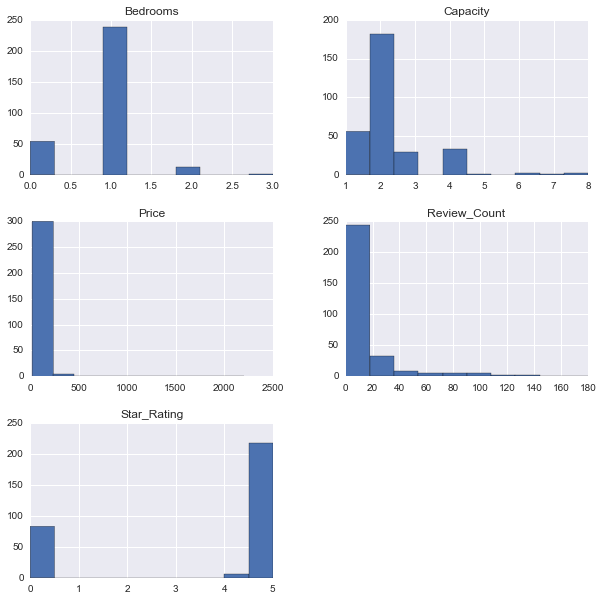

In [49]:
feature_ny_df.hist(figsize=(10,10))

### Thoughts on histograms
* Bedrooms and Capacity look as expected.
* Price has an outlier at $2200, that is ruining the histogram. We must deal with it.
* Review Count is left skewed and should be logged for any model that req's norm. dist features.
* Star Rating is essentially binomial with a rating of either 0 or 5. Could map from continuous to binomial.

### Let's remove that outlier from Price and re-plot:

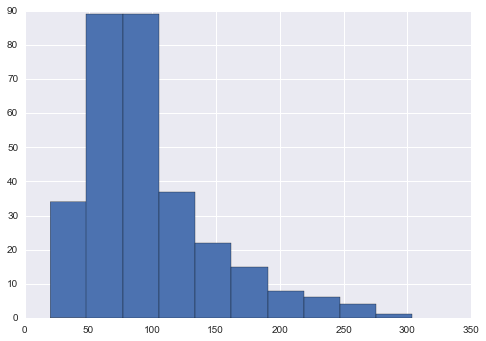

In [51]:
price_outlier_mask = feature_ny_df.Price<2000
feature_ny_df = feature_ny_df[price_outlier_mask]
feature_ny_df.Price.hist()

That looks better. Same as Review Count, Price is left skewed and could benefit from a log tranformation to make it more normally distributed. Let's see what that looks like:

In [52]:
feature_ny_df['log_Price'] = np.log(feature_ny_df.Price)

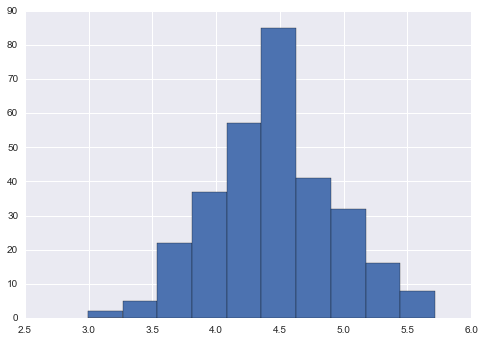

In [53]:
feature_ny_df.log_Price.hist()

The log of Price is normally distributed indeed!

### Scatter Matrices

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x114d39c10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x118231810>]], dtype=object)

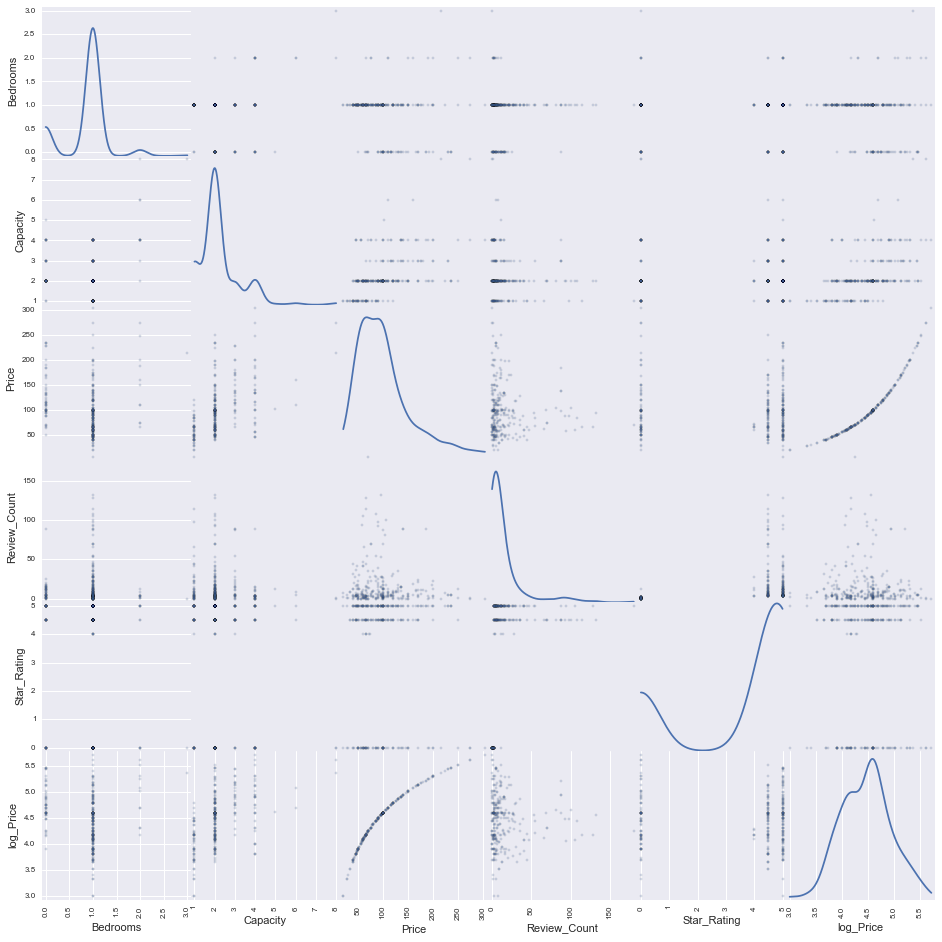

In [55]:
pd.tools.plotting.scatter_matrix(feature_ny_df, alpha=0.2, figsize=(16, 16), diagonal='kde')

#### Overall it does not look like any one feature is particularly correlated with Price (or Log(Price)). Let's look at the actual correlation numbers:

In [56]:
# check collinearity of feature variables
feature_ny_df[ny_feature_cols].corr()

,Bedrooms,Capacity,Price,Review_Count,Star_Rating
Bedrooms,1.000000,0.178469,-0.108111,0.038039,-0.050983
Capacity,0.178469,1.000000,0.500679,-0.108792,-0.090091
Price,-0.108111,0.500679,1.000000,-0.077515,-0.025455
Review_Count,0.038039,-0.108792,-0.077515,1.000000,0.319596
Star_Rating,-0.050983,-0.090091,-0.025455,0.319596,1.000000


#### Price and Capacity are relatively highly correlated at 0.5. No other feature is particularly correlated to Price. Star Rating and Review Count are reasonably correlated at 0.32, suggesting listings with many reviews are well-liked. 

#### Let's see how Property Type and Room Type categorical variables look:

In [58]:
ny_df.Property_Type.value_counts()

Apartment          280
House               14
Townhouse            5
Loft                 4
Other                1
Condominium          1
Bed & Breakfast      1
dtype: int64

In [59]:
ny_df.Room_Type.value_counts()

Private room       156
Entire home/apt    144
Shared room          6
dtype: int64

#### Too many Property Types to make one-hot-encoding worth it (too many additional features. However, will map Room Type to ordinal categorical variable type since I believe you can rank (in order of least desireable to most): 0 : Shared Room, 1 : Private Room, 2 : Entire home/apt

#### Next, I want to look if there's a relationship between listings with a Star Rating greater than 0 and Price (i.e. would I be throwing away valuable info if I mapped Star Rating to binomial.

In [61]:
feature_ny_df.Star_Rating.value_counts()

5.0    132
4.5     85
0.0     82
4.0      6
dtype: int64

In [64]:
sr_group_by = ny_df.groupby('Star_Rating').Price.mean()
sr_group_by

Star_Rating
0.0    125.722892
4.0     66.500000
4.5     93.458824
5.0     99.825758
Name: Price, dtype: float64

In [ ]:
star_rating_mask = feature_ny_df.Star_Rating>1.0
star_rating_df = feature_ny_df[star_rating_mask]

In [72]:
# Correlation between price and Star Rating for listings with a rating greater than 0
np.corrcoef(star_rating_df.Star_Rating, star_rating_df.Price)[0][1]

0.11085439208776988

#### There is some correlation between the Star Rating (when it is not 0) and Price. Though at 0.11 the correlation is not particularly strong. Looking at the Group By, interestingly, listings with a 0 star rating have a higher price. I believe these are properties that are naively priced and have not been stayed in much, if at all.

## Data Preprocessing
* Transform skewed variables (Price, Review Count)
* Map Room Type feature
* Make binomial feature Has_Star_Rating
* Add features mean-Price for each city
* Combine each city's DF into one DF to train model on

In [6]:
def preprocess_data(df, city):
    """Transform data to prepare for model training"""
    
    # add city
    df['City'] = city
    
    # get rid of the price outlier in the NY df
    if city == 'NY':
        price_outlier_mask = df.Price<2000
        df = df[price_outlier_mask]
    
    # add column for mean price (for baseline model)
    df['Avg_Price'] = df.Price.mean()
    
    # take log of price and add mean log(Price)
    df['log_Price'] = np.log(df.Price)
    df['log_Avg_Price'] = df.log_Price.mean()
    
    # Add log of Review Count
    df['log_Review_Count'] = np.log(df.Review_Count)
    
    # get rid of -infs as a result of logs on 0
    df['log_Review_Count'] = np.where(df.log_Review_Count<0, 0, df.log_Review_Count)
    
    # map Room Type variable
    df['Room_Type'] = df.Room_Type.map({'Shared room':0,'Private room':1, 'Entire home/apt':2})
    
    # make 'Has_Star_Rating' feature
    df['Has_Star_Rating'] = np.where(df['Star_Rating']>1.0, 1, 0)
    
    cols = ['Bedrooms','Capacity','Price','Review_Count','Room_Type','Star_Rating','City','Avg_Price',
           'log_Price','log_Avg_Price','log_Review_Count','Has_Star_Rating']
    
    return df[cols]
    #return df
    

In [7]:
processed_ny_df = preprocess_data(ny_df,'NY')

In [144]:
processed_ny_df.head()

,Bedrooms,Capacity,Price,Review_Count,Room_Type,Star_Rating,City,Avg_Price,log_Price,log_Avg_Price,log_Review_Count,Has_Star_Rating
0,1,2,198,17,2,5.0,NY,97.557377,5.288267,4.464576,2.833213,1
2,1,2,149,6,2,5.0,NY,97.557377,5.003946,4.464576,1.791759,1
3,1,4,55,0,2,0.0,NY,97.557377,4.007333,4.464576,0.000000,0
4,1,2,65,3,1,5.0,NY,97.557377,4.174387,4.464576,1.098612,1
5,1,1,61,66,1,4.5,NY,97.557377,4.110874,4.464576,4.189655,1


In [145]:
sf_df.head()

,Bedrooms,Capacity,Id,Price,Property_Type,Review_Count,Room_Type,Star_Rating
0,1,2,1692470,108,Apartment,186,Private room,5.0
1,1,1,7246789,140,Apartment,7,Private room,5.0
2,1,1,1093088,68,Apartment,106,Private room,5.0
3,1,3,3667551,110,Apartment,23,Private room,4.5
4,1,3,9347891,130,House,25,Entire home/apt,5.0


In [8]:
processed_sf_df = preprocess_data(sf_df,'SF')

In [147]:
processed_sf_df.head()

,Bedrooms,Capacity,Price,Review_Count,Room_Type,Star_Rating,City,Avg_Price,log_Price,log_Avg_Price,log_Review_Count,Has_Star_Rating
0,1,2,108,186,1,5.0,SF,123.065359,4.682131,4.705857,5.225747,1
1,1,1,140,7,1,5.0,SF,123.065359,4.941642,4.705857,1.945910,1
2,1,1,68,106,1,5.0,SF,123.065359,4.219508,4.705857,4.663439,1
3,1,3,110,23,1,4.5,SF,123.065359,4.700480,4.705857,3.135494,1
4,1,3,130,25,2,5.0,SF,123.065359,4.867534,4.705857,3.218876,1


In [148]:
la_df.head()

,Bedrooms,Capacity,Id,Price,Property_Type,Review_Count,Room_Type,Star_Rating
0,2,4,12038456,250,Apartment,0,Entire home/apt,0.0
1,1,2,10814985,42,Apartment,3,Private room,5.0
2,1,3,8226591,65,Apartment,7,Entire home/apt,4.5
3,2,4,9463896,140,House,9,Entire home/apt,4.5
4,0,2,12020409,169,House,2,Entire home/apt,0.0


In [9]:
processed_la_df = preprocess_data(la_df,'LA')

In [150]:
processed_la_df.head()

,Bedrooms,Capacity,Price,Review_Count,Room_Type,Star_Rating,City,Avg_Price,log_Price,log_Avg_Price,log_Review_Count,Has_Star_Rating
0,2,4,250,0,2,0.0,LA,83.980392,5.521461,4.338542,0.000000,0
1,1,2,42,3,1,5.0,LA,83.980392,3.737670,4.338542,1.098612,1
2,1,3,65,7,2,4.5,LA,83.980392,4.174387,4.338542,1.945910,1
3,2,4,140,9,2,4.5,LA,83.980392,4.941642,4.338542,2.197225,1
4,0,2,169,2,2,0.0,LA,83.980392,5.129899,4.338542,0.693147,0


### Now, with processed datasets for each city, we shall combine them into one DataFrame

In [10]:
def combine_dfs(df_list):
    data_frame = None
    for df in df_list:
        if data_frame is None:
            data_frame = df
        else:
            data_frame = data_frame.append(df)
    return data_frame

In [11]:
df_list = [processed_ny_df, processed_la_df, processed_sf_df]
combined_df = combine_dfs(df_list)

In [12]:
# One hot encode 'City' feature
# create three dummy variables using get_dummies, then exclude the first dummy column
city_dummies = pd.get_dummies(combined_df.City, prefix='City').iloc[:, 1:]

# concatenate the dummy variable columns onto the original DataFrame
combined_df = pd.concat([combined_df, city_dummies], axis=1)
combined_df.head()

,Bedrooms,Capacity,Price,Review_Count,Room_Type,Star_Rating,City,Avg_Price,log_Price,log_Avg_Price,log_Review_Count,Has_Star_Rating,City_NY,City_SF
0,1,2,198,17,2,5.0,NY,97.557377,5.288267,4.464576,2.833213,1,1,0
2,1,2,149,6,2,5.0,NY,97.557377,5.003946,4.464576,1.791759,1,1,0
3,1,4,55,0,2,0.0,NY,97.557377,4.007333,4.464576,0.000000,0,1,0
4,1,2,65,3,1,5.0,NY,97.557377,4.174387,4.464576,1.098612,1,1,0
5,1,1,61,66,1,4.5,NY,97.557377,4.110874,4.464576,4.189655,1,1,0


In [13]:
# drop the 'City' column since it is no longer needed
combined_df.drop('City', axis=1,inplace=True)

## Listing Price Prediction
* Fit baseline model
* Try permutations of ridge regression (and maybe OLS)
* Find optimal parameter settings with grid search
* try fitting a GBRT

In [14]:
def fit_baseline(df):
    """Fit baseline prediction model where we predict a city's avg for each listing"""
    predictions = df.log_Avg_Price
    y = df.log_Price
    base_r2 = metrics.r2_score(y, predictions)
    base_RMSE = np.sqrt(metrics.mean_squared_error(y, predictions))
    
    return (base_r2, base_RMSE)

In [15]:
base_r2, base_RMSE = fit_baseline(combined_df)
print "Baseline model R-squared: {:.3f}".format(base_r2)
print "Baseline model RMSE: {:.3f}".format(base_RMSE)

Baseline model R-squared: 0.100
Baseline model RMSE: 0.458


#### Baseline R-squared is 0.095, and RMSE is 0.458 Any future models must at least beat this baseline. Let's try Ridge Regression models

In [25]:
# all the features we will consider adding to the model
regression_features = ['log_Review_Count','Star_Rating','Has_Star_Rating','Bedrooms','Capacity','Room_Type','City_NY','City_SF']

In [38]:
feat_combinations = []
# make a list of every possible combination of features, 255 in total
for i in range(len(regression_features)):
   [feat_combinations.append(list(c)) for c in combinations(regression_features, (i+1))]
       

In [97]:
def ridge_combinations(df, feature_combinations):
    """Given a df and list of lists of combinations of features, find best features for regression model.
    
    Returns (tuple)
    -------
    min_RMSE : {float} the lowest RMSE achieved on the test set
    best_features : {list} of the optimal features
    """
    ridge_RMSEs=[]
    min_RMSE = 1e8
    for i, comb in enumerate(feature_combinations):
        X = df[comb]
        y = df.log_Price
    
        # make training and testing split
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=999)
    
        # initialize ridge regression instance
        lr_ridge = Ridge()
    
        # fit to training data
        lr_ridge.fit(X_train, y_train)
    
        # make predictions
        predictions = lr_ridge.predict(X_test)
    
        # calculate RMSE
        ridge_RMSE = np.sqrt(metrics.mean_squared_error(y_test, predictions))
    
        # append RMSE
        ridge_RMSEs.append(ridge_RMSE)
    
        # keep track of min RMSE and best coresponding features
        if ridge_RMSE < min_RMSE:
            print "\ni: {}, min_RMSE: {:.5f}, features: {}".format(i, ridge_RMSE, comb)
            min_RMSE = ridge_RMSE
            best_features = comb
            best_predictions = predictions
            best_y_test = y_test
            
    return (ridge_RMSEs, min_RMSE, best_features, best_predictions, best_y_test)

In [98]:
ridge_RMSEs, min_RMSE, best_features, best_predictions, best_y_test = ridge_combinations(combined_df, feat_combinations)


i: 0, min_RMSE: 0.46295, features: ['log_Review_Count']

i: 1, min_RMSE: 0.46288, features: ['Star_Rating']

i: 4, min_RMSE: 0.40049, features: ['Capacity']

i: 5, min_RMSE: 0.38110, features: ['Room_Type']

i: 12, min_RMSE: 0.37953, features: ['log_Review_Count', 'Room_Type']

i: 18, min_RMSE: 0.37920, features: ['Star_Rating', 'Room_Type']

i: 27, min_RMSE: 0.37825, features: ['Bedrooms', 'Room_Type']

i: 30, min_RMSE: 0.36775, features: ['Capacity', 'Room_Type']

i: 34, min_RMSE: 0.34179, features: ['Room_Type', 'City_SF']

i: 55, min_RMSE: 0.34178, features: ['log_Review_Count', 'Room_Type', 'City_SF']

i: 70, min_RMSE: 0.34099, features: ['Star_Rating', 'Room_Type', 'City_SF']

i: 89, min_RMSE: 0.33446, features: ['Capacity', 'Room_Type', 'City_SF']

i: 124, min_RMSE: 0.33362, features: ['log_Review_Count', 'Capacity', 'Room_Type', 'City_SF']

i: 144, min_RMSE: 0.33285, features: ['Star_Rating', 'Capacity', 'Room_Type', 'City_SF']

i: 161, min_RMSE: 0.33071, features: ['Capacity'

(0, 255)

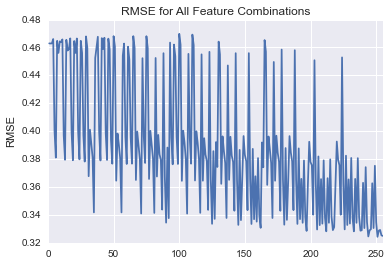

In [94]:
# Let's plot the RMSE for different features:
X = np.linspace(1,255,255)
plt.plot(X, ridge_RMSEs)
plt.title('RMSE for All Feature Combinations')
plt.ylabel('RMSE')
plt.xlim(0,255)

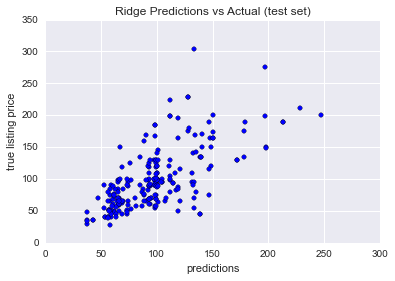

In [103]:
# Let's see how the predictions of the best ridge regression model compare to the true values
plt.scatter(np.exp(best_predictions), np.exp(best_y_test))
plt.xlabel('predictions')
plt.ylabel('true listing price')
plt.title('Ridge Predictions vs Actual (test set)')

#### The optimal Ridge Regression model uses 7 of the 8 potential features (all but No. of Bedrooms). Let's examine the residuals of the optimal model:

In [ ]:
# create instance, train, predict, and calculate residuals for optimal ridge regression model
opt_ridge = Ridge()

['Capacity', 'Room_Type', 'City_NY', 'City_SF']

In [53]:
min_thing = 100
combs = [5,4,3,2,1,2,3,4,5]
for i, c in enumerate(combs):
    
    if c < min_thing:
        min_thing = c
        savei = i
    

In [54]:
savei

4

In [55]:
combs[savei]

1

In [56]:
min_thing

1

In [18]:
gb = ny_df.groupby('Star_Rating').Price.mean()
gb

Star_Rating
0.0    125.722892
4.0     66.500000
4.5     93.458824
5.0     99.825758
Name: Price, dtype: float64

In [20]:
gb2 = ny_df.groupby('Capacity').Price.mean()
gb2

Capacity
1      58.303571
2      94.967033
3     138.827586
4     130.848485
5     102.000000
6     135.000000
7    2200.000000
8     245.000000
Name: Price, dtype: float64

In [22]:
gb3 = ny_df.groupby('Room_Type').Price.mean()
gb3

Room_Type
0     49.333333
1     70.538462
2    143.437500
Name: Price, dtype: float64

In [65]:
gb4 = ny_df.groupby('Bedrooms').Price.mean()
gb4

Bedrooms
0    126.462963
1     88.087866
2    321.500000
3    215.000000
Name: Price, dtype: float64

In [7]:
ny_df['City'] = 'NY'

In [8]:
ny_df.head()

,Bedrooms,Capacity,Id,Price,Property_Type,Review_Count,Room_Type,Star_Rating,City
0,1,2,6882689,198,Apartment,17,2,5,NY
1,2,7,12022627,2200,Apartment,0,2,0,NY
2,1,2,8940740,149,Apartment,6,2,5,NY
3,1,4,12035970,55,Apartment,0,2,0,NY
4,1,2,11642165,65,Apartment,3,1,5,NY


In [9]:
la_df['City'] = 'LA'
sf_df['City'] = 'SF'

In [10]:
ny_df['Avg_Price'] = ny_df.Price.mean()

In [11]:
la_df['Avg_Price'] = la_df.Price.mean()
sf_df['Avg_Price'] = sf_df.Price.mean()

In [12]:
def combine_dfs(df_list):
    data_frame = None
    for df in df_list:
        if data_frame is None:
            data_frame = df
        else:
            data_frame = data_frame.append(df)
    return data_frame

In [13]:
df_list = [ny_df, la_df, sf_df]
combined_df = combine_dfs(df_list)

In [14]:
combined_df.head()

,Bedrooms,Capacity,Id,Price,Property_Type,Review_Count,Room_Type,Star_Rating,City,Avg_Price
0,1,2,6882689,198,Apartment,17,2,5,NY,104.428105
1,2,7,12022627,2200,Apartment,0,2,0,NY,104.428105
2,1,2,8940740,149,Apartment,6,2,5,NY,104.428105
3,1,4,12035970,55,Apartment,0,2,0,NY,104.428105
4,1,2,11642165,65,Apartment,3,1,5,NY,104.428105


In [15]:
# remove that outlier
combined_df = combined_df[combined_df.Price<2000]

In [51]:
combined_df.head()

,Bedrooms,Capacity,Id,Price,Property_Type,Review_Count,Room_Type,Star_Rating,City,Avg_Price
0,1,2,6882689,198,Apartment,17,2,5.0,NY,104.428105
2,1,2,8940740,149,Apartment,6,2,5.0,NY,104.428105
3,1,4,12035970,55,Apartment,0,2,0.0,NY,104.428105
4,1,2,11642165,65,Apartment,3,1,5.0,NY,104.428105
5,1,1,648047,61,Apartment,66,1,4.5,NY,104.428105


# Baseline model where prediction = Average Price for a given city

In [56]:
base_predictions = np.log(combined_df.Avg_Price)

In [59]:
y = np.log(combined_df.Price)

In [60]:
error = y - base_predictions

In [94]:
base_r2 = metrics.r2_score(y, base_predictions)
base_r2

0.022980756866397445

### Baseline r^2 is 0.02298, we will build linear regression model that beats this value.

In [21]:
from sklearn.linear_model import Ridge
from sklearn.cross_validation import train_test_split

In [18]:
# One hot encode 'City' feature
# create three dummy variables using get_dummies, then exclude the first dummy column
city_dummies = pd.get_dummies(combined_df.City, prefix='City').iloc[:, 1:]

# concatenate the dummy variable columns onto the original DataFrame
combined_df = pd.concat([combined_df, city_dummies], axis=1)
combined_df.head()

,Bedrooms,Capacity,Id,Price,Property_Type,Review_Count,Room_Type,Star_Rating,City,Avg_Price,City_NY,City_SF
0,1,2,6882689,198,Apartment,17,2,5.0,NY,104.428105,1,0
2,1,2,8940740,149,Apartment,6,2,5.0,NY,104.428105,1,0
3,1,4,12035970,55,Apartment,0,2,0.0,NY,104.428105,1,0
4,1,2,11642165,65,Apartment,3,1,5.0,NY,104.428105,1,0
5,1,1,648047,61,Apartment,66,1,4.5,NY,104.428105,1,0


In [19]:
# add log of Price and Capacity since skewed distributions
combined_df['log_Capacity'] = np.log(combined_df.Capacity)
combined_df['log_Price'] = np.log(combined_df.Price)

In [67]:
combined_df.head()

,Bedrooms,Capacity,Id,Price,Property_Type,Review_Count,Room_Type,Star_Rating,City,Avg_Price,City_NY,City_SF,log_Capacity,log_Price
0,1,2,6882689,198,Apartment,17,2,5.0,NY,104.428105,1,0,0.693147,5.288267
2,1,2,8940740,149,Apartment,6,2,5.0,NY,104.428105,1,0,0.693147,5.003946
3,1,4,12035970,55,Apartment,0,2,0.0,NY,104.428105,1,0,1.386294,4.007333
4,1,2,11642165,65,Apartment,3,1,5.0,NY,104.428105,1,0,0.693147,4.174387
5,1,1,648047,61,Apartment,66,1,4.5,NY,104.428105,1,0,0.000000,4.110874


In [20]:
feature_cols = ['log_Capacity','City_SF','City_NY','Room_Type']
X = combined_df[feature_cols]
y = combined_df.log_Price

In [88]:
# make training and testing split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [89]:
lr_ridge = Ridge()

In [90]:
lr_ridge.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, solver='auto', tol=0.001)

In [91]:
predictions = lr_ridge.predict(X_test)

In [92]:
ridge_RMSE = np.sqrt(metrics.mean_squared_error(y_test, predictions))
ridge_RMSE

0.32120395686993414

In [99]:
ridge_r2 = metrics.r2_score(y_test, predictions)
ridge_r2

0.54006802837202805

In [101]:
# Let's take a look at the residuals
resids = y_test - predictions

/Users/paulsingman/pyth/data-analysis/venv/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


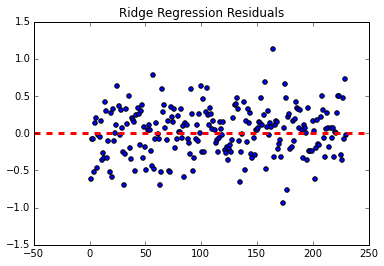

In [104]:
plt.scatter(np.linspace(1,230,230),resids)
plt.axhline(ls='--', linewidth=3, color='r')
plt.title('Ridge Regression Residuals')

### Residuals look like random noise (good) and are homoscedastic

### With the ridge model we achieve an r-squared of .54. Let's try to optimize the alpha parameter to improve this value

In [100]:
alphas = [10e-3, 10e-2, 10e-1, 1, 10, 100]

In [105]:
RMSEs = []
r_squareds = []
for a in alphas:
    lr_ridge = Ridge(alpha=a)
    lr_ridge.fit(X_train, y_train)
    predictions = lr_ridge.predict(X_test)
    RMSEs.append(np.sqrt(metrics.mean_squared_error(y_test, predictions)))
    r_squareds.append(metrics.r2_score(y_test, predictions))
    

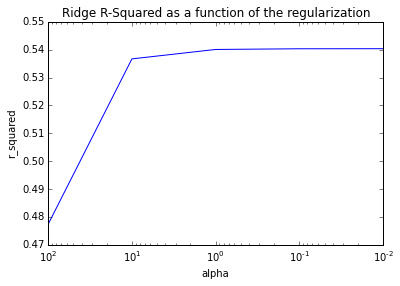

In [109]:
ax = plt.gca()

ax.plot(alphas, r_squareds)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('r_squared')
plt.title('Ridge R-Squared as a function of the regularization')
plt.show()

#### Graph shows that alpha of 1 is reasonably optimal.

# For comparison to the linear model, let's try a Gradient Boosted Regressor
### We'll use grid search to find the optimal parameters and score it by the RMSE

In [22]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.grid_search import GridSearchCV

In [111]:
param_grid = {'learning_rate': [0.01, 0.05, 0.1, 1],
              'max_depth': [4, 6],
              'min_samples_leaf': [3, 5, 9]
              }

gbr = GradientBoostingRegressor(n_estimators=1500)

gs_cv = GridSearchCV(gbr, param_grid, n_jobs=4).fit(X_train, y_train)

In [112]:
# best parameters
gs_cv.best_params_

{'learning_rate': 0.01, 'max_depth': 4, 'min_samples_leaf': 5}

In [113]:
gs_cv.best_score_

0.57007229401371318

In [115]:
opt_gbr = GradientBoostingRegressor(n_estimators=5000, learning_rate=0.01, max_depth=4, min_samples_leaf=5)

In [116]:
opt_gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.01, loss='ls',
             max_depth=4, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=5, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=5000,
             random_state=None, subsample=1.0, verbose=0, warm_start=False)

In [117]:
gbr_rmse = np.sqrt(metrics.mean_squared_error(y_test, opt_gbr.predict(X_test)))
gbr_rmse

0.32653518322187269

In [118]:
# Of course, the simple linear regression model outperforms the complex GBRT. Let's see which features were most important

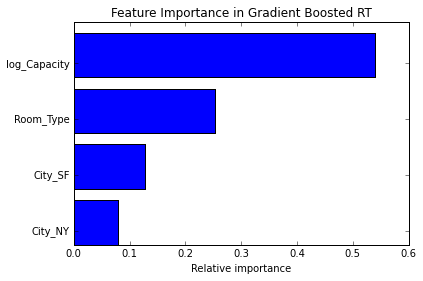

In [122]:
# sort importances
indices = np.argsort(opt_gbr.feature_importances_)
# plot as bar chart
plt.barh(np.arange(len(feature_cols)), opt_gbr.feature_importances_[indices])
plt.yticks(np.arange(len(feature_cols)) + 0.25, np.array(feature_cols)[indices])
_ = plt.xlabel('Relative importance')
plt.title('Feature Importance in Gradient Boosted RT')

#### Unsurprisingly, Capacity is the most important variable

#### Since the Ridge regression was the best model, let's revisit it's parameters

In [124]:
zip(feature_cols,lr_ridge.coef_)

[('log_Capacity', 0.24518156528719259),
 ('City_SF', 0.20559443287383386),
 ('City_NY', 0.012811401975827311),
 ('Room_Type', 0.31176779446528891)]

In [125]:
print "intercept: {}".format(lr_ridge.intercept_)

intercept: 3.82435865152


In [30]:
def test_sample_size(df):
    
    RMSEs_train = []
    r_squareds_train = []
    RMSEs_test = []
    r_squareds_test = []
    
    sample_sizes = np.linspace(101,len(df),9, dtype='int')
    
    X = df[feature_cols]
    y = df.log_Price
    
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    for n in sample_sizes:
        
        X_train_sample = X_train[:n]
        y_train_sample = y_train[:n]
        
        lr_ridge = Ridge()
        lr_ridge.fit(X_train_sample, y_train_sample)
        
        train_predictions = lr_ridge.predict(X_train_sample)
        test_predictions = lr_ridge.predict(X_test)
        
        RMSE_train = np.sqrt(metrics.mean_squared_error(y_train_sample, train_predictions))
        r2_train = metrics.r2_score(y_train_sample, train_predictions)
        
        RMSE_test = np.sqrt(metrics.mean_squared_error(y_test, test_predictions))
        r2_test = metrics.r2_score(y_test, test_predictions)
        
        RMSEs_train.append(RMSE_train)
        r_squareds_train.append(r2_train)
        
        RMSEs_test.append(RMSE_test)
        r_squareds_test.append(r2_test)
        
    return RMSEs_train
        
    

In [31]:
r = test_sample_size(combined_df)

In [ ]:
# Train and predict using different training set sizes
def train_predict(clf, X_train, y_train, X_test, y_test):
    print "------------------------------------------"
    print "Training set size: {}".format(len(X_train))
    train_classifier(clf, X_train, y_train)
    print "F1 score for training set: {}".format(predict_labels(clf, X_train, y_train))
    print "F1 score for test set: {}".format(predict_labels(clf, X_test, y_test))

# TODO: Run the helper function above for desired subsets of training data
# Note: Keep the test set constant

for i in np.linspace(100,300,3, dtype='int'):
    X_train_batch = X_train[:i]
    y_train_batch = y_train[:i]
    train_predict(clf, X_train_batch, y_train_batch, X_test, y_test)

In [131]:
np.linspace(101,len(combined_df),9)

array([ 101.,  203.,  305.,  407.,  509.,  611.,  713.,  815.,  917.])

In [32]:
r

[0.30359143921067072,
 0.31549223634636808,
 0.31041212106898797,
 0.3115850933509044,
 0.30680665444980826,
 0.30529085684436519,
 0.30566388785703086,
 0.30566388785703086,
 0.30566388785703086]